In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
train = pd.read_csv('C:/............./train.csv')
test = pd.read_csv('C:/.........../test.csv')
subm = pd.read_csv('C:/............../sample_submission.csv')

In [8]:
COMMENT = 'comment_text'
train.shape, test.shape

((159571, 8), (153164, 2))

In [9]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)

In [5]:
#count number of 0
print('Percentage of unlabelled comments is ', len(train[train['none']!=0])/len(train)*100)

Percentage of unlabelled comments is  89.83211235124176


In [6]:
%matplotlib inline
tab=train.astype(bool).sum(axis=0) #numero di non zeri sulle colonne
tab=pd.DataFrame(tab)
tab[1:9].rename(index=str, columns={0: "count"})

,count
comment_text,159571
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405
none,143346


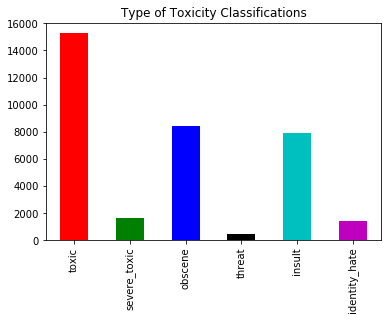

In [16]:
#tab.rename(columns={0: 'type_of_comment', 1: 'A'}, inplace=True)
tab[2:8].plot(kind='bar', color='rgbkcm', legend=False, title='Type of Toxicity Classifications')

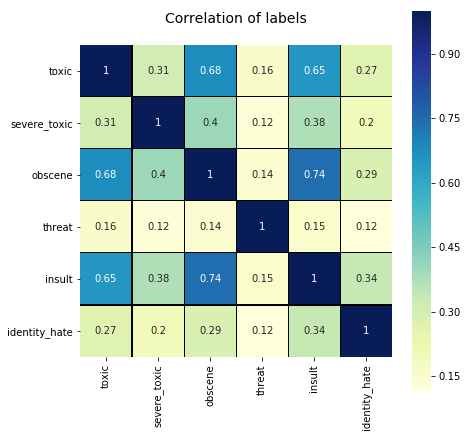

In [10]:
plt.figure(figsize=(7,7))
plt.title('Correlation of labels',y=1.05,size=14)
sns.heatmap(train[label_cols].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap="YlGnBu",
           linecolor='black',annot=True)

In [10]:
n = train.shape[0]#dimensione di train
vec = TfidfVectorizer(norm='l2',ngram_range=(1,2),stop_words='english', use_idf=1,  max_df=0.9, min_df=3, strip_accents='unicode', smooth_idf=True)
vec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=1,
        vocabulary=None)

In [11]:
train_dt = vec.fit_transform(train[COMMENT]) #learn vocabulary and transform in document term matrix
test_dt = vec.transform(test[COMMENT]) #transform in document term matrix
train_dt,test_dt 

(<159571x276286 sparse matrix of type '<class 'numpy.float64'>'
 	with 5874487 stored elements in Compressed Sparse Row format>,
 <153164x276286 sparse matrix of type '<class 'numpy.float64'>'
 	with 4550318 stored elements in Compressed Sparse Row format>)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_dt, train[label_cols], test_size=0.33, random_state=42)
  
print("Random X_train shape = {}".format(X_train.shape))
print("Random y_train shape = {}".format(y_train.shape))
print("Random X_val shape = {}".format(X_val.shape))
print("Random y_val shape = {}".format(y_val.shape))

Random X_train shape = (106912, 276286)
Random y_train shape = (106912, 6)
Random X_val shape = (52659, 276286)
Random y_val shape = (52659, 6)


In [13]:
#MultinomialNB #trovare best alpha
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score,roc_auc_score
from sklearn.model_selection import GridSearchCV

parameters = {'clf__alpha':[0.00001,0.001,0.5,0.75]}

pipeline = Pipeline([
    #('vect', CountVectorizer())
    #('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
grid_search = GridSearchCV(pipeline, parameters, scoring='roc_auc', verbose=1)
for j in range(0,len(label_cols)):
    print('fit', j)  
    grid_search.fit(X_train,y_train[label_cols[j]].values)
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters= grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

fit 0
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.7s finished


Best score: 0.906
Best parameters set:
	clf__alpha: 0.5
fit 1
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.3s finished


Best score: 0.955
Best parameters set:
	clf__alpha: 0.001
fit 2
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s finished


Best score: 0.922
Best parameters set:
	clf__alpha: 0.001
fit 3
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.3s finished


Best score: 0.921
Best parameters set:
	clf__alpha: 0.001
fit 4
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.8s finished


Best score: 0.918
Best parameters set:
	clf__alpha: 0.001
fit 5
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: 0.912
Best parameters set:
	clf__alpha: 0.001


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.3s finished


In [33]:
#MultinomialNB with best alpha
from sklearn.metrics import recall_score,roc_auc_score, average_precision_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

preds = np.zeros((len(y_val), len(label_cols)))
preds_test= np.zeros((len(test), len(label_cols)))
rec= []
roc=[]
pr_auc=[]

NB = MultinomialNB(alpha=0.001)
for j in range(0,len(label_cols)):
    print('fit', j)
    m = NB.fit(X_train,y_train[label_cols[j]])
    preds[:,j] = m.predict_proba(X_val)[:,1]
    rec.append(recall_score(y_val[label_cols[j]], m.predict(X_val))) 
    roc.append(roc_auc_score(y_val[label_cols[j]],  preds[:,j]))
    pr_auc.append(average_precision_score(y_val[label_cols[j]],  preds[:,j]))
    preds_test[:,j] = m.predict_proba(test_dt)[:,1]
print('roc_Auc',np.mean(roc))
print('rec',np.mean(rec))
print('pr_auc',np.mean(pr_auc))

fit 0
fit 1
fit 2
fit 3
fit 4
fit 5
roc_Auc 0.922006773463
rec 0.41273461621
pr_auc 0.433341278601


In [23]:
from sklearn.metrics import confusion_matrix
TP=0
TN=0
FN=0
FP=0
for j in range(0,len(label_cols)):
    conf=[]
    print('fit', j)
    m = NB.fit(X_train,y_train[label_cols[j]])
    conf.append(confusion_matrix(y_val[label_cols[j]], m.predict(X_val)))
    TN+=conf[0][0][0]
    FP+=conf[0][0][1]
    FN+=conf[0][1][0]
    TP+=conf[0][1][1]

print('TP ', TP/6,'FP ',FP/6, 'TN ', TN/6, 'FN', FN/6)

fit 0
fit 1
fit 2
fit 3
fit 4
fit 5
TP  990.5 FP  409.5 TN  50298.5 FN 960.5


In [97]:
#prova per verificare i TP TN FP FN
m = NB.fit(X_train,y_train[label_cols[1]])
y_pred=m.predict(X_val)
y_reali= y_val[label_cols[1]]TP=0
TN=0
FN=0
FP=0
for i in range(0,len(y_pred)):
    if y_reali.values[i]==0 and y_pred[i]==0:
        TN+=1
    if y_pred[i]==1 and y_reali.values[i]==1:
        TP+=1
    if y_pred[i]==1 and y_reali.values[i]==0:
        FP+=1
    if y_pred[i]==0 and y_reali.values[i]==1:
        FN+=1
print('TP ', TP,'FP ',FP, 'TN ', TN, 'FN', FN)

TP  206 FP  311 TN  51822 FN 320


In [16]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds_test, columns = label_cols)], axis=1)
submission.head()
submission.to_csv('submissionNB.csv', index=False)#score di kaggle per multinomialNB con l1 0.9358, con l2 0.9203

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999867,8.807203e-03,9.855877e-01,1.825943e-04,9.606975e-01,9.018370e-01
1,0000247867823ef7,0.002414,1.224336e-05,1.761812e-03,7.683139e-06,1.463483e-04,2.705395e-05
2,00013b17ad220c46,0.001065,4.961171e-04,9.581118e-04,9.318515e-05,9.659876e-04,7.825480e-04
3,00017563c3f7919a,0.000018,3.042996e-07,5.320452e-07,9.691874e-08,5.950185e-07,2.327851e-07
4,00017695ad8997eb,0.001216,5.561849e-04,9.056777e-04,2.519093e-05,9.704734e-04,2.279795e-04


In [16]:
#logistic regression #verifica
from sklearn.model_selection import GridSearchCV
parameters = {'clf__C':[1,2,3,4,5,6,7]}

pipeline = Pipeline([
    #('vect', CountVectorizer())
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

grid_search = GridSearchCV(pipeline, parameters, scoring='roc_auc', verbose=1)

for j in range(0,len(label_cols)):
    print('fit', j)  
    grid_search.fit(X_train,y_train[label_cols[j]].values)
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters= grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

fit 0
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   41.1s finished


Best score: 0.968
Best parameters set:
	clf__C: 4
fit 1
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   47.3s finished


Best score: 0.985
Best parameters set:
	clf__C: 1
fit 2
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   37.7s finished


Best score: 0.984
Best parameters set:
	clf__C: 2
fit 3
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   37.4s finished


Best score: 0.978
Best parameters set:
	clf__C: 4
fit 4
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   41.8s finished


Best score: 0.974
Best parameters set:
	clf__C: 2
fit 5
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   45.0s finished


Best score: 0.971
Best parameters set:
	clf__C: 3


In [35]:
#LogisticRegression with best parameter
preds = np.zeros((len(y_val), len(label_cols)))
preds_test= np.zeros((len(test), len(label_cols)))
rec= []
roc=[]
pr_auc=[]
lr = LogisticRegression(C=4)
for j in range(0,len(label_cols)):
    print('fit', j)
    m = lr.fit(X_train,y_train[label_cols[j]])
    preds[:,j] = m.predict_proba(X_val)[:,1]
    rec.append(recall_score(y_val[label_cols[j]], m.predict(X_val))) 
    roc.append(roc_auc_score(y_val[label_cols[j]],  preds[:,j]))
    pr_auc.append(average_precision_score(y_val[label_cols[j]],  preds[:,j]))
    preds_test[:,j] = m.predict_proba(test_dt)[:,1]
print('roc_Auc',np.mean(roc)) #best parameter for l1=7, for l2 =4
print('rec',np.mean(rec))
print('pr_auc',np.mean(pr_auc))

fit 0
fit 1
fit 2
fit 3
fit 4
fit 5
roc_Auc 0.978051747551
rec 0.392079449131
pr_auc 0.626320271372


In [25]:
from sklearn.metrics import confusion_matrix
TP=0
TN=0
FN=0
FP=0
for j in range(0,len(label_cols)):
    conf=[]
    print('fit', j)
    m = lr.fit(X_train,y_train[label_cols[j]])
    conf.append(confusion_matrix(y_val[label_cols[j]], m.predict(X_val)))
    TN+=conf[0][0][0]
    FP+=conf[0][0][1]
    FN+=conf[0][1][0]
    TP+=conf[0][1][1]

print('TP ', TP/6,'FP ',FP/6, 'TN ', TN/6, 'FN', FN/6)

fit 0
fit 1
fit 2
fit 3
fit 4
fit 5
TP  1083.33333333 FP  147.333333333 TN  50560.6666667 FN 867.666666667


In [20]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds_test, columns = label_cols)], axis=1)
submission
#submission.to_csv('submissionLOGRl2.csv', index=False)#score di kaggle con LogisticRegression with l1 0.9659, with l2=0.9732

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998764,0.172064,0.996358,0.024600,0.939165,0.306446
1,0000247867823ef7,0.004988,0.001655,0.004764,0.001096,0.004369,0.002415
2,00013b17ad220c46,0.020810,0.002187,0.008069,0.001004,0.010148,0.002821
3,00017563c3f7919a,0.002825,0.001332,0.002187,0.000967,0.002308,0.000765
4,00017695ad8997eb,0.023114,0.002673,0.006011,0.001578,0.012820,0.001812
5,0001ea8717f6de06,0.008388,0.002142,0.005293,0.000918,0.009318,0.001902
6,00024115d4cbde0f,0.004951,0.001118,0.004159,0.000579,0.003995,0.001738
7,000247e83dcc1211,0.622591,0.002483,0.039259,0.002525,0.069189,0.003630
8,00025358d4737918,0.008176,0.001477,0.016760,0.001176,0.012768,0.002110
9,00026d1092fe71cc,0.005278,0.001361,0.003717,0.001117,0.008964,0.002273
